In [15]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import random

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle

'''Algos'''
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance, TimeSeriesKMeans
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.regularizers import l1

'''Dataset analysis'''
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from statistics import stdev
from math import sqrt

In [16]:
# K.tensorflow_backend._get_available_gpus()
pair = [0,1,2,3,8,9,10,11]
anticlock_sequence = [0,1,3,2]
clockwise_sequence = [2,3,1,0]
resolution = 40
location = {8:[1,1],
            9:[-1,1],
            10:[1,-1],
            11:[-1,-1]}

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


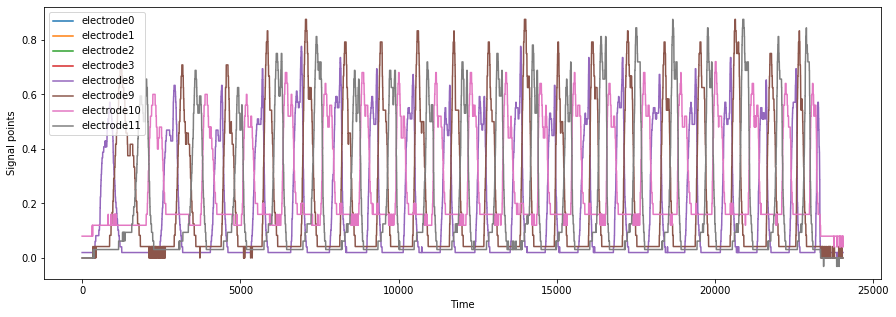

In [17]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

def get_electrode_data(filename):
    electrodes_points = pd.read_csv(filename)
    electrodes_points.columns = electrodes_points.columns.astype(float)
    electrodes_points.columns = electrodes_points.columns.astype(int)
    return electrodes_points.loc[:,pair]

def plot_electrode_data(electrodes_points):
    plt.figure(figsize= (15,5))
    for electrode in electrodes_points.columns:
        plt.plot(electrodes_points.index,electrodes_points.loc[:,electrode],label='electrode' + str(electrode))
    plt.xlabel('Time')
    plt.ylabel('Signal points')
    plt.legend()
    
plot_electrode_data(get_electrode_data('circle_v6_anticlock1.csv'))
# plt.xlim([0,10000])
# plot_electrode_data(get_electrode_data('circle.csv'))
# plot_electrode_data(get_electrode_data('y_axis.csv'))
# plt.xlim([0,1000])

In [18]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def find_peak(data,height=0.2,distance=350):
    peaks={}
    adjusted_peaks = {}
    for electrode in data.columns:
        peaks[electrode] = find_peaks(data.loc[:,electrode],height = height, distance= distance)[0]
        value = data.loc[:,electrode].to_numpy()
        for i,index in enumerate(peaks[electrode]):
            try: 
                segment = value[int(index-distance/3):int(index+distance/3)]
                popt,pcov = curve_fit(gaus,np.linspace(int(index-distance/3),int(index+distance/3-1),
                                                       int(index+distance/3-1) - int(index-distance/3) + 1),
                                      segment,p0=[value[index],index,distance/4])
                peaks[electrode][i] = int(popt[1])
            except:
                continue
        print('number of peaks in electrode ', electrode, ' = ',len(peaks[electrode]))
    return peaks

def plot_peaks(data,peaks):
    for electrode in data.columns:
        plt.plot(data.index[peaks[electrode]],data.loc[peaks[electrode],electrode],'x')
        

def electrode_sequence(sequence):
    elec_sequence=[]
    for i in sequence:
        elec_sequence.append(pair[i])
    return elec_sequence

def rotate(l,n):
    return l[n:] + l[:n]

def arrange_peaks_seq(peaks,elec_sequence):
#     print(peaks)
    
    start = min(chain(*peaks.values()))
    
    for key in peaks.keys():
        if start in peaks[key]:
            start_electrode = key

    
    while True:
#         print(elec_sequence,start_electrode)
        if elec_sequence[0] == start_electrode:
            break
        else:
            elec_sequence = rotate(elec_sequence,1)
    i = 0
    final_peak = []
    final_sequence = []
    prev_peak = 0
    while True:
#         print('electrode_sequence',elec_sequence,peaks,elec_sequence[i%len(elec_sequence)])
        cycle = int(i/len(elec_sequence))
        try:
            peak = peaks[elec_sequence[i%len(elec_sequence)]][0]
#             print('peaks ',elec_sequence[i%len(elec_sequence)],' has peaks ', peaks[elec_sequence[i%len(elec_sequence)]])
        except:
            break
        if peak > prev_peak:
#             print('adding peaks',i,peak)
            final_peak.append(peak)
            prev_peak = peak
            peaks[elec_sequence[i%len(elec_sequence)]] = peaks[elec_sequence[i%len(elec_sequence)]][1:]
            final_sequence.append(elec_sequence[i%len(elec_sequence)])
        else:
            print('error in finding peaks',prev_peak,peak)
            break
        i += 1
    return final_peak,final_sequence

def arrange_coord_seq(final_sequence,direction='clockwise'):
    final_coords = []
    for i,elec in enumerate(final_sequence):
        final_coords.append(location[final_sequence[i]])
    final_coords = np.array(final_coords)
    return final_coords


def create_training_data_square(data,final_peak,final_coords):
    X_data = data.loc[final_peak[0],:].to_numpy()
    y_data = np.array(final_coords[0])
    
    for i,index in enumerate(final_peak):
        try:
            index_difference = (final_peak[i+1] - final_peak[i])/resolution         
        except:
            break
        
        X = data.loc[int(index),:].to_numpy()
        y = np.array(final_coords[i]).astype(float)
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from ',y)
        for j in range(resolution):
#             print('>>>>>>>>>>>>>  ',X,y)
            X_data = np.vstack((X_data,X))
            y_data = np.vstack((y_data,y))
            index += index_difference
            X = data.loc[int(index),:].to_numpy()
#             print('inside training data collection loop: ',i)        
            y_difference = (final_coords[i+1] - final_coords[i])/resolution
            y += y_difference 
            print(y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data,y_data

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

data = get_electrode_data('circle_v6_clockwise1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=1400)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
print(final_coords)
X11,y11  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_clockwise2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=800)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X12,y12  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_clockwise3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=400)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X17,y17  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_clockwise4.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=300)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X18,y18  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_clockwise5.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=300)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X20,y20  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_clockwise6.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=300)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X21,y21  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_anticlock1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=800)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X13,y13  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_anticlock2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=1300)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X14,y14  = create_training_data_square(data,final_peak,final_coords)

data = get_electrode_data('circle_v6_anticlock3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=600)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X15,y15  = create_training_data_square(data,final_peak,final_coords)

data = get_electrode_data('circle_v6_anticlock4.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=400)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X16,y16  = create_training_data_square(data,final_peak,final_coords)


data = get_electrode_data('circle_v6_anticlock5.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=200)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X19,y19  = create_training_data_square(data,final_peak,final_coords)



data = get_electrode_data('circle_v6_anticlock6.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=300)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X22,y22  = create_training_data_square(data,final_peak,final_coords)

#### Analyse straight line

In [ ]:
resolution = 40
def generate_straight_line_trining_data(data,start,end):
    X_data = []
    y_data = []
    start = np.array(start).astype(float)
    end = np.array(end).astype(float)
    data = data.loc[:,:].to_numpy()
    y_difference = (end - start)/resolution
    index_difference = len(data)/resolution
    index = 0
    coords = start
    X_data = data[int(index),:]
    y_data = coords
#     print(X_data,y_data)
    while True:
        index += index_difference
        coords += y_difference
        try:
#             print('add coords',coords)
            if any(abs(x)>1 for x in coords):
                break
            X_data = np.vstack((X_data,data[int(index),:]))
            y_data = np.vstack((y_data,coords))
        except:
            break

    X_data = np.array(X_data)
    y_data = np.array(y_data)
#     print(y_data)
    return X_data,y_data

In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

data = get_electrode_data('circle_v6_line18.csv')
plot_electrode_data(data)
plt.xlim([100,1000])
resolution = 40
data = get_electrode_data('circle_v6_line1.csv').loc[400:1900,:]
X1,y1 = generate_straight_line_trining_data(data,[-1,1], [1,1])
data = get_electrode_data('circle_v6_line2.csv').loc[550:1950,:]
X2,y2 = generate_straight_line_trining_data(data,[-1,0.5], [1,0.5])

data = get_electrode_data('circle_v6_line3.csv').loc[300:2000,:]
X3,y3 = generate_straight_line_trining_data(data,[-1,0], [1,0])

data = get_electrode_data('circle_v6_line4.csv').loc[450:2000,:]
X4,y4 = generate_straight_line_trining_data(data,[-1,-0.5], [1,-0.5])
data = get_electrode_data('circle_v6_line5.csv').loc[400:1900,:]
X5,y5 = generate_straight_line_trining_data(data,[-1,-1], [1,-1])
data = get_electrode_data('circle_v6_line6.csv').loc[400:2100,:]
X6,y6 = generate_straight_line_trining_data(data,[-1,1], [-1,-1])
data = get_electrode_data('circle_v6_line7.csv').loc[600:2600,:]
X7,y7 = generate_straight_line_trining_data(data,[-0.5,1], [-0.5,-1])
data = get_electrode_data('circle_v6_line8.csv').loc[650:2100,:]
X8,y8 = generate_straight_line_trining_data(data,[0,1], [0,-1])
data = get_electrode_data('circle_v6_line9.csv').loc[250:1650,:]
X9,y9 = generate_straight_line_trining_data(data,[0.5,1], [0.5,-1])
data = get_electrode_data('circle_v6_line10.csv').loc[300:1400,:]
X10,y10 = generate_straight_line_trining_data(data,[1,1], [1,-1])


data = get_electrode_data('circle_v6_line11.csv').loc[300:800,:]
X23,y23 = generate_straight_line_trining_data(data,[-1,1], [1,-1])
data = get_electrode_data('circle_v6_line12.csv').loc[270:700,:]
X24,y24 = generate_straight_line_trining_data(data,[-1,1], [1,-1])
data = get_electrode_data('circle_v6_line13.csv').loc[360:700,:]
X25,y25 = generate_straight_line_trining_data(data,[-1,1], [1,-1])
data = get_electrode_data('circle_v6_line14.csv').loc[310:820,:]
X26,y26 = generate_straight_line_trining_data(data,[-1,1], [1,-1])

data = get_electrode_data('circle_v6_line15.csv').loc[250:750,:]
X27,y27 = generate_straight_line_trining_data(data,[1,1], [-1,-1])
ata = get_electrode_data('circle_v6_line16.csv').loc[250:860,:]
X28,y28 = generate_straight_line_trining_data(data,[1,1], [-1,-1])
ata = get_electrode_data('circle_v6_line17.csv').loc[220:920,:]
X29,y29 = generate_straight_line_trining_data(data,[1,1], [-1,-1])
ata = get_electrode_data('circle_v6_line18.csv').loc[200:1000,:]
X30,y30 = generate_straight_line_trining_data(data,[1,1], [-1,-1])
# print(X10)

In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

number = 11
Y_axis,coord = eval('X'+str(number)),eval('y'+str(number))
X_axis = np.linspace(1,len(Y_axis),len(Y_axis))

for i in range(Y_axis.shape[1]):
    ax1.plot(X_axis,Y_axis[:,i])

ax2.plot(coord[:,0],coord[:,1],'x')
data = get_electrode_data('circle_v6_clockwise1.csv')
plot_electrode_data(data)

In [ ]:

def plotacc(history,j):
    y = history.history['acc']
    x = range(1,len(y)+1)
    plt.plot(x,y,label=str(j) + ' datasets training ')
    
    return y[-1]
    
def plotval_loss(history):
    y = history.history['val_loss']
    x = range(1,len(y)+1)
    plt.plot(x,y)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Error")
    print('Minimum MSE: ', min(y))
    return y[-1]

def acc_eval(y_true, y_pred):
    for y in [y_true,y_pred]:
        if type(y) == pd.DataFrame:
            y = y.to_numpy()
    return np.average(np.sum(y_true - y_pred,axis=0))

In [5]:

dataset_num = 30
X_data = np.vstack((eval('X'+str(i)) for i in range(1,dataset_num + 1)))
y_data = np.vstack((eval('y'+str(i)) for i in range(1,dataset_num + 1)))


np.savetxt(r'D:\\signal_ntd_trackpad\V6_training_data.csv',np.hstack((X_data,y_data)),delimiter=",",fmt='%.3f')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

model = Sequential()
model.add(Dense(units = 6,activation="linear", input_dim=4))
model.add(Dense(8, activation="linear"))
model.add(Dense(14, activation="linear"))
model.add(Dense(20, activation="linear"))
model.add(Dense(40, activation="linear"))
model.add(Dense(80, activation="relu"))
model.add(Dense(160, activation="linear"))
model.add(Dense(320, activation="linear"))
model.add(Dense(2, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 100
batch_size = 128
history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test),verbose=0)


y_pred = model.predict(X_train,verbose=1)
accuracy_score_MAE_bias = mean_absolute_error(y_train, y_pred, multioutput='raw_values')
print('accuracy_bias_score = ', accuracy_score_MAE_bias)
y_pred = model.predict(X_test,verbose=1)
accuracy_score_MAE_variance = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('accuracy_variance_score = ', accuracy_score_MAE_variance - accuracy_score_MAE_bias)
# plt.plot(j*10, 1 - accuracy,'x',label='accuracy with ' + str(j) + ' datasets')
    
clf1 = svm.SVR()
clf1.fit(X_train,y_train[:,0])
clf2 = svm.SVR()
clf2.fit(X_train,y_train[:,1])

y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred = np.vstack((y_pred1,y_pred2)).T
print(y_pred.shape,y_test.shape)
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('sklearn svr accuracy  = ', 1 - accuracy_score_MAE)


print(os.getcwd())
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

model.save('ntd_v6.1_trackpad_model.h5')

C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


NameError: name 'X1' is not defined

## Train on whole two panels



In [6]:
def generate_straight_line_trining_data(data,start,end):
    X_data = []
    y_data = []
    start = np.array(start).astype(float)
    end = np.array(end).astype(float)
    data = data.loc[:,:].to_numpy()
    y_difference = (end - start)/resolution
    index_difference = len(data)/resolution
    index = 0
    coords = start
    X_data = data[int(np.round(index,0)),:]
    y_data = coords
    print(index,index_difference,start,y_difference)
    while True:
        index += index_difference
        coords += y_difference
        try:
            X_data = np.vstack((X_data,data[int(np.round(index,0)),:]))
            y_data = np.vstack((y_data,coords))
        except:
            break
    
    X_data = np.array(X_data)
    y_data = np.array(y_data)
#     print(y_data)
    return X_data,y_data

In [19]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

a = 0
b = -0

# data = get_electrode_data('circle_v6.2_line43.csv')
# plot_electrode_data(data)
# plt.xlim([400,1500])
# data = get_electrode_data('circle_v6.2_line44.csv')
# plot_electrode_data(data)
# plt.xlim([300,1100])
# data = get_electrode_data('circle_v6.2_line45.csv')
# plot_electrode_data(data)
# plt.xlim([200,1100])
# data = get_electrode_data('circle_v6.2_line46.csv')
# plot_electrode_data(data)
# plt.xlim([200,1000])
# data = get_electrode_data('circle_v6.2_line47.csv')
# plot_electrode_data(data)
# plt.xlim([300,900])
# data = get_electrode_data('circle_v6.2_line48.csv')
# plot_electrode_data(data)
# plt.xlim([300,800])
# data = get_electrode_data('circle_v6.2_line49.csv')
# plot_electrode_data(data)
# plt.xlim([300,750])
# data = get_electrode_data('circle_v6.2_line50.csv')
# plot_electrode_data(data)
# plt.xlim([400,900])

resolution = 100
data = get_electrode_data('circle_v6.2_line1.csv').loc[250+a:720+b,:]
X101,y101 = generate_straight_line_trining_data(data,[-2,1], [2,1])
data = get_electrode_data('circle_v6.2_line2.csv').loc[200+a:870+b,:]
X102,y102 = generate_straight_line_trining_data(data,[2,1], [-2,1])
data = get_electrode_data('circle_v6.2_line3.csv').loc[220+a:690+b,:]
X103,y103 = generate_straight_line_trining_data(data,[-2,0.5], [2,0.5])
data = get_electrode_data('circle_v6.2_line4.csv').loc[175+a:675+b,:]
X104,y104 = generate_straight_line_trining_data(data,[2,0.5], [-2,0.5])
data = get_electrode_data('circle_v6.2_line5.csv').loc[170+a:700+b,:]
X105,y105 = generate_straight_line_trining_data(data,[-2,0], [2,0])
data = get_electrode_data('circle_v6.2_line6.csv').loc[125+a:690+b,:]
X106,y106 = generate_straight_line_trining_data(data,[2,0], [-2,0])
data = get_electrode_data('circle_v6.2_line7.csv').loc[260+a:730+b,:]
X107,y107 = generate_straight_line_trining_data(data,[-2,-0.5], [2,-0.5])
data = get_electrode_data('circle_v6.2_line8.csv').loc[180+a:650+b,:]
X108,y108 = generate_straight_line_trining_data(data,[2,-0.5], [-2,-0.5])
data = get_electrode_data('circle_v6.2_line9.csv').loc[200+a:430+b,:]
X109,y109 = generate_straight_line_trining_data(data,[-2,-1], [2,-1])
data = get_electrode_data('circle_v6.2_line10.csv').loc[190+a:450+b,:]
X110,y110 = generate_straight_line_trining_data(data,[2,-1], [-2,-1])
data = get_electrode_data('circle_v6.2_line29.csv').loc[420+a:1280+b,:]
X129,y129 = generate_straight_line_trining_data(data,[-2,-1], [2,-1])
data = get_electrode_data('circle_v6.2_line30.csv').loc[400+a:1700+b,:]
X130,y130 = generate_straight_line_trining_data(data,[2,-1], [-2,-1])
data = get_electrode_data('circle_v6.2_line31.csv').loc[120+a:400+b,:]
X131,y131 = generate_straight_line_trining_data(data,[-2,-1], [2,-1])
data = get_electrode_data('circle_v6.2_line32.csv').loc[150+a:440+b,:]
X132,y132 = generate_straight_line_trining_data(data,[2,-1], [-2,-1])
data = get_electrode_data('circle_v6.2_line33.csv').loc[370+a:960+b,:]
X133,y133 = generate_straight_line_trining_data(data,[-2,-1], [2,-1])
data = get_electrode_data('circle_v6.2_line34.csv').loc[370+a:1600+b,:]
X134,y134 = generate_straight_line_trining_data(data,[2,-1], [-2,-1])

data = get_electrode_data('circle_v6.2_line35.csv').loc[450+a:1010+b,:]
X135,y135 = generate_straight_line_trining_data(data,[-2,1], [2,1])
data = get_electrode_data('circle_v6.2_line36.csv').loc[230+a:710+b,:]
X136,y136 = generate_straight_line_trining_data(data,[2,1], [-2,1])
data = get_electrode_data('circle_v6.2_line37.csv').loc[390+a:1040+b,:]
X137,y137 = generate_straight_line_trining_data(data,[-2,1], [2,1])
data = get_electrode_data('circle_v6.2_line38.csv').loc[280+a:730+b,:]
X138,y138 = generate_straight_line_trining_data(data,[2,1], [-2,1])
# print(X101)

data = get_electrode_data('circle_v6.2_line39.csv').loc[240+a:530+b,:]
X139,y139 = generate_straight_line_trining_data(data,[-2,0], [2,0])
data = get_electrode_data('circle_v6.2_line40.csv').loc[205+a:335+b,:]
X140,y140 = generate_straight_line_trining_data(data,[2,0], [-2,0])
data = get_electrode_data('circle_v6.2_line41.csv').loc[100+a:340+b,:]
X141,y141 = generate_straight_line_trining_data(data,[-2,0], [2,0])
data = get_electrode_data('circle_v6.2_line42.csv').loc[120+a:420+b,:]
X142,y142 = generate_straight_line_trining_data(data,[2,0], [-2,0])

resolution = 100
data = get_electrode_data('circle_v6.2_line43.csv').loc[450+a:1450+b,:]
X157,y157 = generate_straight_line_trining_data(data,[-2,1], [0,-1])
data = get_electrode_data('circle_v6.2_line44.csv').loc[350+a:1000+b,:]
X158,y158 = generate_straight_line_trining_data(data,[0,-1], [-2,1])
data = get_electrode_data('circle_v6.2_line45.csv').loc[270+a:1060+b,:]
X159,y159 = generate_straight_line_trining_data(data,[-2,-1], [0,1])
data = get_electrode_data('circle_v6.2_line46.csv').loc[300+a:910+b,:]
X160,y160 = generate_straight_line_trining_data(data,[0,1], [-2,-1])
data = get_electrode_data('circle_v6.2_line47.csv').loc[300+a:860+b,:]
X161,y161 = generate_straight_line_trining_data(data,[0,1], [2,-1])
data = get_electrode_data('circle_v6.2_line48.csv').loc[300+a:800+b,:]
X162,y162 = generate_straight_line_trining_data(data,[2,-1], [0,1])
data = get_electrode_data('circle_v6.2_line49.csv').loc[300+a:700+b,:]
X163,y163 = generate_straight_line_trining_data(data,[0,-1], [2,1])
data = get_electrode_data('circle_v6.2_line50.csv').loc[410+a:890+b,:]
X164,y164 = generate_straight_line_trining_data(data,[2,1], [0,-1])

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
0 4.71 [-2.  1.] [0.04 0.  ]
0 6.71 [2. 1.] [-0.04  0.  ]
0 4.71 [-2.   0.5] [0.04 0.  ]
0 5.01 [2.  0.5] [-0.04  0.  ]
0 5.31 [-2.  0.] [0.04 0.  ]
0 5.66 [2. 0.] [-0.04  0.  ]
0 4.71 [-2.  -0.5] [0.04 0.  ]
0 4.71 [ 2.  -0.5] [-0.04  0.  ]
0 2.31 [-2. -1.] [0.04 0.  ]
0 2.61 [ 2. -1.] [-0.04  0.  ]
0 8.61 [-2. -1.] [0.04 0.  ]
0 13.01 [ 2. -1.] [-0.04  0.  ]
0 2.81 [-2. -1.] [0.04 0.  ]
0 2.91 [ 2. -1.] [-0.04  0.  ]
0 5.91 [-2. -1.] [0.04 0.  ]
0 12.31 [ 2. -1.] [-0.04  0.  ]
0 5.61 [-2.  1.] [0.04 0.  ]
0 4.81 [2. 1.] [-0.04  0.  ]
0 6.51 [-2.  1.] [0.04 0.  ]
0 4.51 [2. 1.] [-0.04  0.  ]
0 2.91 [-2.  0.] [0.04 0.  ]
0 1.31 [2. 0.] [-0.04  0.  ]
0 2.41 [-2.  0.] [0.04 0.  ]
0 3.01 [2. 0.] [-0.04  0.  ]
0 10.01 [-2.  1.] [ 0.02 -0.02]
0 6.51 [ 0. -1.] [-0.02  0.02]
0 7.91 [-2. -1.] [0.02 0.02]
0 6.11 [0. 1.] [-0.02 -0.02]
0 5.61 [0. 1.] [ 0.02 -0.02]
0 5.01 [ 2. -1.] [-0.02  0.02]
0 4.01 [ 0. -1.] [0.02 0.02]
0 4.81 [2. 1.] [-0.02 -0.02]

In [20]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

# data = get_electrode_data('circle_v6.2_line11.csv')
# plot_electrode_data(data)
# plt.xlim([150,400])
# data = get_electrode_data('circle_v6.2_line12.csv')
# plot_electrode_data(data)
# plt.xlim([100,320])
# data = get_electrode_data('circle_v6.2_line13.csv')
# plot_electrode_data(data)
# plt.xlim([100,400])
# data = get_electrode_data('circle_v6.2_line14.csv')
# plot_electrode_data(data)
# plt.xlim([300,700])
# data = get_electrode_data('circle_v6.2_line15.csv')
# plot_electrode_data(data)
# plt.xlim([100,550])
# data = get_electrode_data('circle_v6.2_line16.csv')
# plot_electrode_data(data)
# plt.xlim([125,370])
# data = get_electrode_data('circle_v6.2_line17.csv')
# plot_electrode_data(data)
# plt.xlim([100,450])
# data = get_electrode_data('circle_v6.2_line18.csv')
# plot_electrode_data(data)
# plt.xlim([150,400])
# data = get_electrode_data('circle_v6.2_line19.csv')
# plot_electrode_data(data)
# plt.xlim([100,400])
# data = get_electrode_data('circle_v6.2_line20.csv')
# plot_electrode_data(data)
# plt.xlim([100,400])


resolution = 50
data = get_electrode_data('circle_v6.2_line11.csv').loc[180+a:370+b,:]
X111,y111 = generate_straight_line_trining_data(data,[-2,1], [-2,-1])
data = get_electrode_data('circle_v6.2_line12.csv').loc[125+a:300+b,:]
X112,y112 = generate_straight_line_trining_data(data,[-2,-1], [-2,1])
data = get_electrode_data('circle_v6.2_line13.csv').loc[125+a:380+b,:]
X113,y113 = generate_straight_line_trining_data(data,[-1.5,1], [-1.5,-1])
data = get_electrode_data('circle_v6.2_line14.csv').loc[390+a:690+b,:]
X114,y114 = generate_straight_line_trining_data(data,[-1.5,-1], [-1.5,1])
data = get_electrode_data('circle_v6.2_line15.csv').loc[100+a:500+b,:]
X115,y115 = generate_straight_line_trining_data(data,[-1,1], [-1,-1])
data = get_electrode_data('circle_v6.2_line16.csv').loc[145+a:370+b,:]
X116,y116 = generate_straight_line_trining_data(data,[-1,-1], [-1,1])
data = get_electrode_data('circle_v6.2_line17.csv').loc[110+a:425+b,:]
X117,y117 = generate_straight_line_trining_data(data,[-0.5,1], [-0.5,-1])
data = get_electrode_data('circle_v6.2_line18.csv').loc[175+a:400+b,:]
X118,y118 = generate_straight_line_trining_data(data,[-0.5,-1], [-0.5,1])
data = get_electrode_data('circle_v6.2_line19.csv').loc[150+a:350+b,:]
X119,y119 = generate_straight_line_trining_data(data,[0,1], [0,-1])
data = get_electrode_data('circle_v6.2_line20.csv').loc[125+a:310+b,:]
X120,y120 = generate_straight_line_trining_data(data,[0,-1], [0,1])

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
0 3.82 [-2.  1.] [ 0.   -0.04]
0 3.52 [-2. -1.] [0.   0.04]
0 5.12 [-1.5  1. ] [ 0.   -0.04]
0 6.02 [-1.5 -1. ] [0.   0.04]
0 8.02 [-1.  1.] [ 0.   -0.04]
0 4.52 [-1. -1.] [0.   0.04]
0 6.32 [-0.5  1. ] [ 0.   -0.04]
0 4.52 [-0.5 -1. ] [0.   0.04]
0 4.02 [0. 1.] [ 0.   -0.04]
0 3.72 [ 0. -1.] [0.   0.04]


In [21]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

# data = get_electrode_data('circle_v6.2_line21.csv')
# plot_electrode_data(data)
# plt.xlim([100,350])
# data = get_electrode_data('circle_v6.2_line22.csv')
# plot_electrode_data(data)
# plt.xlim([120,350])
# data = get_electrode_data('circle_v6.2_line23.csv')
# plot_electrode_data(data)
# plt.xlim([150,500])
# data = get_electrode_data('circle_v6.2_line24.csv')
# plot_electrode_data(data)
# plt.xlim([100,350])
# data = get_electrode_data('circle_v6.2_line25.csv')
# plot_electrode_data(data)
# plt.xlim([100,500])
# data = get_electrode_data('circle_v6.2_line26.csv')
# plot_electrode_data(data)
# plt.xlim([150,450])
# data = get_electrode_data('circle_v6.2_line27.csv')
# plot_electrode_data(data)
# plt.xlim([150,320])
# data = get_electrode_data('circle_v6.2_line28.csv')
# plot_electrode_data(data)
# plt.xlim([150,350])

resolution = 50
data = get_electrode_data('circle_v6.2_line21.csv').loc[140+a:340+b,:]
X121,y121 = generate_straight_line_trining_data(data,[0.5,1], [0.5,-1])
data = get_electrode_data('circle_v6.2_line22.csv').loc[135+a:320+b,:]
X122,y122 = generate_straight_line_trining_data(data,[0.5,-1], [0.5,1])
data = get_electrode_data('circle_v6.2_line23.csv').loc[200+a:490+b,:]
X123,y123 = generate_straight_line_trining_data(data,[1,1], [1,-1])
data = get_electrode_data('circle_v6.2_line24.csv').loc[140+a:330+b,:]
X124,y124 = generate_straight_line_trining_data(data,[1,-1], [1,1])
data = get_electrode_data('circle_v6.2_line25.csv').loc[130+a:450+b,:]
X125,y125 = generate_straight_line_trining_data(data,[1.5,1], [1.5,-1])
data = get_electrode_data('circle_v6.2_line26.csv').loc[160+a:420+b,:]
X126,y126 = generate_straight_line_trining_data(data,[1.5,-1], [1.5,1])
data = get_electrode_data('circle_v6.2_line27.csv').loc[160+a:300+b,:]
X127,y127 = generate_straight_line_trining_data(data,[2,1], [2,-1])
data = get_electrode_data('circle_v6.2_line28.csv').loc[180+a:330+b,:]
X128,y128 = generate_straight_line_trining_data(data,[2,-1], [2,1])

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
0 4.02 [0.5 1. ] [ 0.   -0.04]
0 3.72 [ 0.5 -1. ] [0.   0.04]
0 5.82 [1. 1.] [ 0.   -0.04]
0 3.82 [ 1. -1.] [0.   0.04]
0 6.42 [1.5 1. ] [ 0.   -0.04]
0 5.22 [ 1.5 -1. ] [0.   0.04]
0 2.82 [2. 1.] [ 0.   -0.04]
0 3.02 [ 2. -1.] [0.   0.04]


In [22]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())



resolution = 400
data = get_electrode_data('circle_v6.2_corner1.csv').loc[:,:]
X143,y143 = generate_straight_line_trining_data(data,[-2,1], [-2,1])
data = get_electrode_data('circle_v6.2_corner2.csv').loc[:,:]
X144,y144 = generate_straight_line_trining_data(data,[-2,-1], [-2,-1])
data = get_electrode_data('circle_v6.2_corner3.csv').loc[:,:]
X145,y145 = generate_straight_line_trining_data(data,[2,1], [2,1])
data = get_electrode_data('circle_v6.2_corner4.csv').loc[:,:]
X146,y146 = generate_straight_line_trining_data(data,[2,-1], [2,-1])

data = get_electrode_data('circle_v6.2_point1.csv').loc[:,:]
X147,y147 = generate_straight_line_trining_data(data,[-2,0], [-2,0])
data = get_electrode_data('circle_v6.2_point2.csv').loc[:,:]
X148,y148 = generate_straight_line_trining_data(data,[2,0], [2,0])
data = get_electrode_data('circle_v6.2_point3.csv').loc[:,:]
X149,y149 = generate_straight_line_trining_data(data,[-1,1], [-1,1])
data = get_electrode_data('circle_v6.2_point4.csv').loc[:,:]
X150,y150 = generate_straight_line_trining_data(data,[0,1], [0,1])
data = get_electrode_data('circle_v6.2_point5.csv').loc[:,:]
X151,y151 = generate_straight_line_trining_data(data,[1,1], [1,1])
data = get_electrode_data('circle_v6.2_point6.csv').loc[:,:]
X152,y152 = generate_straight_line_trining_data(data,[-1,-1], [-1,-1])
data = get_electrode_data('circle_v6.2_point7.csv').loc[:,:]
X153,y153 = generate_straight_line_trining_data(data,[0,-1], [0,-1])
data = get_electrode_data('circle_v6.2_point8.csv').loc[:,:]
X154,y154 = generate_straight_line_trining_data(data,[1,-1], [1,-1])
data = get_electrode_data('circle_v6.2_point9.csv').loc[:,:]
X155,y155 = generate_straight_line_trining_data(data,[0,0], [0,0])
data = get_electrode_data('circle_v6.2_point10.csv').loc[:,:]
X156,y156 = generate_straight_line_trining_data(data,[-1,0], [-1,0])
data = get_electrode_data('circle_v6.2_point11.csv').loc[:,:]
X157,y157 = generate_straight_line_trining_data(data,[1,0], [1,0])

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
0 2.93 [-2.  1.] [0. 0.]
0 3.4575 [-2. -1.] [0. 0.]
0 3.9375 [2. 1.] [0. 0.]
0 7.4325 [ 2. -1.] [0. 0.]
0 9.3075 [-2.  0.] [0. 0.]
0 11.5125 [2. 0.] [0. 0.]
0 9.6675 [-1.  1.] [0. 0.]
0 13.595 [0. 1.] [0. 0.]
0 10.9225 [1. 1.] [0. 0.]
0 11.005 [-1. -1.] [0. 0.]
0 14.28 [ 0. -1.] [0. 0.]
0 13.3925 [ 1. -1.] [0. 0.]
0 34.17 [0. 0.] [0. 0.]
0 4.7125 [-1.  0.] [0. 0.]
0 3.92 [1. 0.] [0. 0.]


(100, 8)


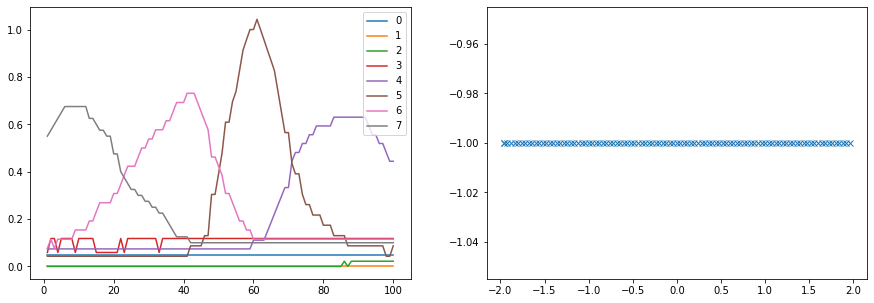

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

number = 109
Y_axis,coord = eval('X'+str(number)),eval('y'+str(number))
X_axis = np.linspace(1,len(Y_axis),len(Y_axis))
print(Y_axis.shape)
for i in range(Y_axis.shape[1]):
    ax1.plot(X_axis,Y_axis[:,i],label=str(i))
ax1.legend()
ax2.plot(coord[:,0],coord[:,1],'x')

# 36 feature is better, extra layer is better, more nonlineaer is better,scaler is better

In [85]:
dataset_num = 64
X_data = np.vstack((eval('X'+str(i)) for i in range(101,100+dataset_num + 1)))
y_data = np.vstack((eval('y'+str(i)) for i in range(101,100+dataset_num + 1)))

def add_feature(input_data):
    print(input_data)
#     print(input_data.reshape(-1,1) @ np.array([input_data]))
    flat_matrix = []
    multi_three = []
    multiply_matrix = np.triu(input_data.reshape(-1,1) @ np.array([input_data]))
    divide_matrix = input_data.reshape(-1,1) @ (np.divide(1,np.array([input_data])))
    for index, x in np.ndenumerate(multiply_matrix):
        if index[1] >= index [0]:
            flat_matrix.append(x)
            for i in range(len(input_data)):
                if i >= index[1]:
                    multi_three.append(x*input_data[i])
    print(len(flat_matrix),len(multi_three))
    input_data = np.hstack((input_data,flat_matrix,multi_three))
#     flat_sum = []
#     for index, x in np.ndenumerate(multiply_matrix):
#         if index[1] > index [0]:
#             flat_sum.append(input_data[index[1]]+input_data[index[0]])
#     input_data = np.hstack((input_data,flat_sum))
#     flat_matrix = []
#     print(divide_matrix.shape)
#     input_data = np.hstack((input_data,divide_matrix.flatten()))
    input_data = np.clip(input_data,0,1)
    return input_data
X_data = np.apply_along_axis(add_feature,1,X_data)

scaler = pp.MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# X_data = np.vstack((X1_data,X2_data))
# y_data = np.vstack((y1_data,y1_data))
print(X_data.shape,y_data.shape)
np.savetxt(r'D:\\signal_ntd_trackpad\V62_training_data.csv',np.hstack((X_data,y_data)),delimiter=",",fmt='%.3f')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)
feature = X_train.shape[1] 
print(feature)
model = Sequential()
model.add(Dense(units = feature,activation="linear", input_dim=feature))
model.add(Dense(feature*2, activation="relu"))
model.add(Dense(feature*4, activation="relu"))
model.add(Dense(feature*8, activation="relu"))
model.add(Dense(feature*16, activation="relu"))
model.add(Dense(2, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 20
batch_size = 128
for i in range(1):
    history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test),verbose=1)
    os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
    print(os.getcwd())
    model.save('ntd_v67_trackpad_model.h5')
    y_pred = model.predict(X_train,verbose=0)
    accuracy_score_MAE_bias = mean_absolute_error(y_train, y_pred, multioutput='raw_values')
    print('accuracy_bias_score = ', accuracy_score_MAE_bias)
    y_pred = model.predict(X_test,verbose=0)
    accuracy_score_MAE_variance = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    print('accuracy_variance_score = ', accuracy_score_MAE_variance - accuracy_score_MAE_bias)

clf1 = DecisionTreeRegressor(max_depth=20)
clf1.fit(X_train,y_train[:,0])
clf2 = DecisionTreeRegressor(max_depth=20)
clf2.fit(X_train,y_train[:,1])

y_pred1 = clf1.predict(X_train)
y_pred2 = clf2.predict(X_train)
y_pred = np.vstack((y_pred1,y_pred2)).T
print(y_pred.shape,y_test.shape)
accuracy_score_MAE_bias = mean_absolute_error(y_train, y_pred, multioutput='raw_values')
print('accuracy_bias_score = ', accuracy_score_MAE_bias)
y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred = np.vstack((y_pred1,y_pred2)).T
accuracy_score_MAE_variance = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('accuracy_variance_score = ', accuracy_score_MAE_variance - accuracy_score_MAE_bias)


print(os.getcwd())
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

model.save('ntd_v62_trackpad_model.h5')
with open('ntd_v62_trackpad_scaler.pkl', 'wb') as fid:
    pickle.dump(scaler, fid)

C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in matmul
  # This is added back by InteractiveShellApp.init_pa

[0.4   0.    0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.425 0.    0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.475 0.    0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.5   0.    0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.525 0.    0.    0.059 0.037 0.043 0.038 0.1  ]
36 120
[0.55  0.    0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.55  0.033 0.    0.118 0.037 0.043 0.077 0.1  ]
36 120
[0.525 0.033 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.525 0.033 0.    0.059 0.037 0.043 0.038 0.1  ]
36 120
[0.525 0.033 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.525 0.033 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.525 0.067 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.525 0.067 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.5   0.1   0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.45  0.133 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.425 0.133 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.4   0.133 0.    0.059 0.037 0.043 0.077 0.1  ]
36 120
[0.375 0.133 0.    0.059 0.037 

[0.375 0.033 0.    0.118 0.037 0.043 0.077 0.2  ]
36 120
[0.4   0.033 0.    0.118 0.037 0.043 0.077 0.2  ]
36 120
[0.425 0.033 0.    0.059 0.037 0.043 0.077 0.2  ]
36 120
[0.425 0.033 0.    0.118 0.037 0.043 0.077 0.2  ]
36 120
[0.475 0.033 0.    0.059 0.037 0.043 0.077 0.2  ]
36 120
[0.525 0.033 0.    0.118 0.037 0.087 0.077 0.2  ]
36 120
[0.525 0.033 0.    0.118 0.037 0.087 0.077 0.2  ]
36 120
[0.525 0.033 0.    0.118 0.037 0.087 0.077 0.2  ]
36 120
[0.575 0.033 0.    0.118 0.037 0.043 0.077 0.2  ]
36 120
[0.6   0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.6   0.033 0.    0.118 0.037 0.087 0.077 0.175]
36 120
[0.6   0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.625 0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.65  0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.65  0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.65  0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.65  0.033 0.    0.118 0.037 0.043 0.077 0.175]
36 120
[0.675 0.067 0.    0.118 0.037 

36 120
[0.05  0.2   0.    0.118 0.074 0.217 0.231 0.15 ]
36 120
[0.05  0.167 0.    0.176 0.074 0.217 0.192 0.15 ]
36 120
[0.05  0.133 0.    0.176 0.074 0.217 0.192 0.15 ]
36 120
[0.05  0.1   0.    0.176 0.074 0.261 0.192 0.15 ]
36 120
[0.05  0.1   0.022 0.235 0.074 0.304 0.154 0.15 ]
36 120
[0.05  0.067 0.    0.235 0.074 0.348 0.154 0.175]
36 120
[0.025 0.067 0.    0.235 0.074 0.391 0.115 0.175]
36 120
[0.05  0.067 0.    0.235 0.074 0.391 0.115 0.15 ]
36 120
[0.05  0.067 0.    0.235 0.074 0.391 0.115 0.15 ]
36 120
[0.05  0.033 0.    0.235 0.074 0.435 0.115 0.15 ]
36 120
[0.05  0.033 0.    0.294 0.074 0.478 0.115 0.15 ]
36 120
[0.05  0.033 0.022 0.294 0.074 0.478 0.115 0.15 ]
36 120
[0.05  0.033 0.    0.294 0.074 0.522 0.115 0.15 ]
36 120
[0.05  0.    0.    0.353 0.074 0.522 0.077 0.15 ]
36 120
[0.05  0.    0.022 0.353 0.074 0.565 0.115 0.15 ]
36 120
[0.05  0.    0.022 0.353 0.074 0.565 0.115 0.15 ]
36 120
[0.05  0.    0.022 0.412 0.074 0.522 0.115 0.125]
36 120
[0.05  0.    0.022 0.471

[0.025 0.    0.043 0.059 0.704 0.13  0.115 0.1  ]
36 120
[0.025 0.    0.043 0.059 0.704 0.13  0.115 0.1  ]
36 120
[0.025 0.    0.065 0.059 0.704 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.065 0.059 0.704 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.065 0.059 0.667 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.087 0.059 0.667 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.087 0.059 0.63  0.087 0.115 0.1  ]
36 120
[0.025 0.    0.109 0.059 0.63  0.087 0.115 0.1  ]
36 120
[0.025 0.    0.109 0.059 0.593 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.109 0.059 0.593 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.109 0.059 0.556 0.043 0.115 0.1  ]
36 120
[0.025 0.    0.13  0.059 0.556 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.13  0.059 0.519 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.13  0.059 0.444 0.087 0.115 0.1  ]
36 120
[0.025 0.    0.152 0.059 0.519 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.152 0.059 0.519 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.152 0.059 0.556 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.13  0.059 0.593 

36 120
[0.025 0.    0.022 0.118 0.63  0.13  0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.63  0.13  0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.63  0.174 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.63  0.174 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.593 0.174 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.593 0.217 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.556 0.217 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.519 0.261 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.519 0.261 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.519 0.304 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.481 0.304 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.481 0.304 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.481 0.304 0.077 0.075]
36 120
[0.025 0.    0.    0.118 0.444 0.391 0.077 0.075]
36 120
[0.025 0.    0.    0.118 0.407 0.391 0.077 0.075]
36 120
[0.025 0.    0.    0.118 0.37  0.435 0.077 0.075]
36 120
[0.025 0.    0.022 0.118 0.333 0.522 0.115 0.075]
36 120
[0.025 0.    0.022 0.118

36 120
[0.025 0.    0.    0.059 0.037 0.043 0.231 0.55 ]
36 120
[0.    0.    0.    0.059 0.037 0.043 0.231 0.5  ]
36 120
[0.    0.    0.    0.059 0.037 0.043 0.231 0.425]
36 120
[0.025 0.    0.    0.059 0.037 0.043 0.231 0.375]
36 120
[0.025 0.    0.    0.059 0.037 0.043 0.231 0.375]
36 120
[0.    0.    0.    0.059 0.037 0.043 0.231 0.375]
36 120
[0.    0.    0.    0.059 0.037 0.043 0.231 0.325]
36 120
[0.025 0.    0.    0.059 0.037 0.043 0.231 0.325]
36 120
[0.    0.    0.    0.059 0.    0.043 0.231 0.3  ]
36 120
[0.    0.    0.    0.059 0.    0.043 0.231 0.3  ]
36 120
[ 0.056  0.    -0.031  0.     0.     0.     0.333  0.5  ]
36 120
[ 0.056  0.    -0.031  0.     0.     0.     0.333  0.5  ]
36 120
[ 0.     0.    -0.031  0.     0.     0.     0.333  0.536]
36 120
[ 0.056  0.    -0.031  0.     0.     0.     0.333  0.607]
36 120
[ 0.056  0.    -0.031  0.     0.     0.     0.333  0.714]
36 120
[0.056 0.    0.    0.    0.    0.    0.333 0.75 ]
36 120
[ 0.056  0.    -0.031  0.     0.     0.  

36 120
[0.025 0.1   0.    0.059 0.037 0.043 0.654 0.1  ]
36 120
[0.025 0.1   0.022 0.059 0.037 0.043 0.654 0.1  ]
36 120
[0.05  0.133 0.022 0.059 0.037 0.043 0.577 0.1  ]
36 120
[0.025 0.133 0.    0.059 0.037 0.043 0.577 0.1  ]
36 120
[0.05  0.167 0.    0.059 0.037 0.043 0.538 0.1  ]
36 120
[0.05  0.2   0.    0.059 0.037 0.043 0.538 0.075]
36 120
[0.025 0.2   0.    0.059 0.037 0.043 0.5   0.1  ]
36 120
[0.05  0.267 0.022 0.059 0.037 0.043 0.462 0.1  ]
36 120
[0.05  0.267 0.    0.059 0.037 0.043 0.462 0.1  ]
36 120
[0.05  0.333 0.    0.059 0.037 0.043 0.385 0.1  ]
36 120
[0.05  0.367 0.022 0.059 0.037 0.043 0.385 0.1  ]
36 120
[0.05  0.4   0.    0.059 0.037 0.043 0.346 0.1  ]
36 120
[0.05  0.4   0.    0.059 0.037 0.043 0.308 0.1  ]
36 120
[0.05  0.467 0.022 0.059 0.037 0.043 0.269 0.1  ]
36 120
[0.05  0.567 0.022 0.059 0.037 0.043 0.231 0.1  ]
36 120
[0.05  0.633 0.022 0.059 0.037 0.043 0.192 0.075]
36 120
[0.05  0.667 0.    0.059 0.037 0.043 0.192 0.075]
36 120
[0.05  0.7   0.022 0.059

36 120
[0.05  0.033 0.022 0.706 0.074 0.348 0.115 0.125]
36 120
[0.05  0.033 0.022 0.706 0.074 0.348 0.115 0.125]
36 120
[0.05  0.    0.022 0.824 0.074 0.304 0.115 0.125]
36 120
[0.05  0.033 0.022 0.824 0.074 0.261 0.115 0.125]
36 120
[0.05  0.033 0.022 0.882 0.074 0.261 0.115 0.125]
36 120
[0.05  0.033 0.022 0.941 0.074 0.217 0.115 0.125]
36 120
[0.05  0.033 0.022 1.    0.074 0.217 0.115 0.125]
36 120
[0.05  0.033 0.022 1.    0.074 0.217 0.115 0.125]
36 120
[0.05  0.033 0.022 1.    0.074 0.174 0.115 0.125]
36 120
[0.05  0.033 0.022 1.    0.074 0.174 0.115 0.125]
36 120
[0.05  0.033 0.022 1.    0.074 0.174 0.115 0.125]
36 120
[0.05  0.    0.022 1.    0.074 0.174 0.115 0.125]
36 120
[0.05  0.    0.022 1.    0.037 0.174 0.115 0.125]
36 120
[0.05  0.    0.022 1.    0.074 0.174 0.115 0.125]
36 120
[0.05  0.033 0.022 1.059 0.037 0.174 0.115 0.125]
36 120
[0.025 0.    0.087 0.765 0.074 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.087 0.765 0.074 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.087 0.824

36 120
[0.025 0.    0.609 0.118 0.074 0.043 0.038 0.075]
36 120
[0.025 0.    0.609 0.118 0.074 0.043 0.038 0.075]
36 120
[0.025 0.    0.587 0.118 0.074 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.565 0.118 0.111 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.565 0.118 0.111 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.5   0.118 0.111 0.043 0.038 0.05 ]
36 120
[0.    0.    0.5   0.118 0.111 0.043 0.038 0.05 ]
36 120
[0.025 0.    0.457 0.118 0.148 0.043 0.038 0.05 ]
36 120
[0.025 0.    0.435 0.118 0.148 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.413 0.118 0.148 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.391 0.118 0.185 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.37  0.118 0.185 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.348 0.118 0.185 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.326 0.118 0.222 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.304 0.118 0.222 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.261 0.118 0.259 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.261 0.118 0.259 0.087 0.038 0.05 ]
36 120
[0.025 0.    0.239 0.118

36 120
[0.    0.    0.031 0.    0.333 0.917 0.    0.   ]
36 120
[0.    0.    0.031 0.    0.333 1.    0.    0.   ]
36 120
[0.    0.    0.031 0.    0.267 1.083 0.    0.   ]
36 120
[0.    0.    0.031 0.    0.2   1.167 0.043 0.   ]
36 120
[0.    0.    0.031 0.    0.133 1.25  0.043 0.   ]
36 120
[0.    0.    0.031 0.    0.133 1.333 0.043 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.333 0.043 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.25  0.043 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.25  0.043 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.167 0.087 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.167 0.087 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.083 0.087 0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.083 0.13  0.   ]
36 120
[0.    0.    0.031 0.    0.067 1.    0.174 0.   ]
36 120
[0.    0.    0.031 0.    0.067 0.917 0.217 0.   ]
36 120
[0.    0.    0.031 0.    0.067 0.833 0.217 0.   ]
36 120
[0.    0.    0.031 0.    0.067 0.75  0.261 0.   ]
36 120
[0.    0.    0.031 0.   

36 120
[0.    0.    0.    0.    0.2   1.583 0.043 0.067]
36 120
[0.    0.    0.    0.    0.133 1.583 0.043 0.067]
36 120
[0.    0.    0.    0.    0.133 1.583 0.043 0.067]
36 120
[0.    0.    0.    0.    0.067 1.667 0.087 0.067]
36 120
[0.    0.    0.    0.    0.067 1.75  0.087 0.067]
36 120
[0.    0.    0.    0.    0.067 1.75  0.087 0.067]
36 120
[0.    0.    0.    0.    0.067 1.75  0.087 0.067]
36 120
[0.    0.    0.    0.    0.    1.667 0.13  0.067]
36 120
[0.    0.    0.    0.    0.067 1.583 0.13  0.067]
36 120
[0.    0.    0.    0.    0.    1.5   0.174 0.067]
36 120
[0.    0.    0.    0.    0.    1.5   0.174 0.067]
36 120
[0.    0.    0.    0.    0.    1.417 0.174 0.067]
36 120
[0.    0.    0.    0.    0.    1.    0.304 0.067]
36 120
[0.    0.    0.    0.    0.    1.    0.304 0.067]
36 120
[0.    0.    0.    0.    0.    0.75  0.391 0.067]
36 120
[0.    0.    0.    0.    0.    0.583 0.435 0.067]
36 120
[0.    0.    0.    0.    0.    0.417 0.478 0.067]
36 120
[0.    0.    0.    0.   

[0.    0.    0.    0.    0.    0.    0.391 0.367]
36 120
[0.    0.    0.    0.    0.    0.    0.391 0.4  ]
36 120
[0.    0.    0.    0.    0.    0.    0.348 0.433]
36 120
[0.    0.    0.    0.    0.    0.    0.304 0.5  ]
36 120
[0.    0.    0.    0.    0.    0.    0.304 0.533]
36 120
[0.    0.    0.    0.    0.    0.    0.261 0.567]
36 120
[0.    0.    0.    0.    0.    0.    0.217 0.667]
36 120
[0.    0.    0.    0.    0.    0.    0.174 0.733]
36 120
[0.   0.   0.   0.   0.   0.   0.13 0.8 ]
36 120
[0.    0.    0.    0.    0.    0.    0.087 0.867]
36 120
[0.    0.    0.    0.    0.    0.    0.043 0.9  ]
36 120
[0.    0.    0.    0.    0.    0.    0.    0.867]
36 120
[0.    0.    0.    0.    0.    0.    0.    0.833]
36 120
[0.    0.    0.    0.    0.    0.    0.    0.767]
36 120
[0.  0.  0.  0.  0.  0.  0.  0.7]
36 120
[0.  0.  0.  0.  0.  0.  0.  0.7]
36 120
[0.    0.    0.    0.    0.    0.    0.    0.667]
36 120
[0.    0.    0.    0.    0.    0.    0.    0.633]
36 120
[ 0.     0.   

36 120
[0.467 0.022 0.    0.    0.    0.    0.    0.051]
36 120
[0.489 0.022 0.    0.    0.    0.    0.    0.051]
36 120
[0.533 0.022 0.    0.    0.    0.    0.    0.051]
36 120
[0.644 0.043 0.    0.    0.    0.    0.    0.068]
36 120
[0.667 0.043 0.    0.    0.    0.    0.    0.068]
36 120
[0.689 0.065 0.    0.    0.    0.    0.027 0.051]
36 120
[0.689 0.065 0.    0.    0.    0.    0.    0.051]
36 120
[0.689 0.087 0.    0.    0.    0.    0.027 0.051]
36 120
[0.667 0.087 0.    0.    0.    0.    0.027 0.051]
36 120
[0.644 0.109 0.    0.    0.    0.    0.027 0.051]
36 120
[0.644 0.109 0.    0.    0.    0.    0.027 0.051]
36 120
[0.622 0.13  0.    0.    0.    0.    0.027 0.051]
36 120
[0.578 0.152 0.    0.    0.    0.    0.027 0.034]
36 120
[0.578 0.152 0.    0.    0.    0.    0.027 0.034]
36 120
[0.533 0.174 0.    0.    0.    0.    0.027 0.034]
36 120
[0.533 0.174 0.    0.    0.    0.    0.027 0.034]
36 120
[0.511 0.174 0.    0.    0.    0.    0.027 0.034]
36 120
[0.511 0.174 0.    0.   

36 120
[ 0.356  0.    -0.022  0.     0.037  0.     0.054  0.271]
36 120
[0.378 0.    0.    0.    0.037 0.    0.054 0.271]
36 120
[0.378 0.    0.    0.    0.037 0.    0.054 0.271]
36 120
[0.356 0.022 0.    0.    0.037 0.    0.081 0.203]
36 120
[0.356 0.022 0.    0.    0.037 0.    0.081 0.203]
36 120
[0.333 0.043 0.    0.    0.037 0.    0.135 0.169]
36 120
[0.222 0.109 0.    0.    0.037 0.    0.189 0.119]
36 120
[0.2   0.13  0.    0.    0.037 0.    0.216 0.102]
36 120
[0.2   0.13  0.    0.    0.037 0.    0.216 0.102]
36 120
[0.067 0.217 0.    0.    0.037 0.    0.243 0.068]
36 120
[0.067 0.217 0.    0.    0.037 0.    0.243 0.051]
36 120
[0.067 0.217 0.    0.    0.037 0.    0.243 0.051]
36 120
[0.044 0.217 0.    0.    0.037 0.    0.243 0.051]
36 120
[ 0.022  0.239 -0.022  0.     0.037  0.     0.27   0.051]
36 120
[0.022 0.239 0.    0.    0.037 0.    0.27  0.051]
36 120
[ 0.022  0.239 -0.022  0.     0.037  0.     0.243  0.034]
36 120
[ 0.022  0.239 -0.022  0.     0.037  0.     0.243  0.034]

[0.022 0.087 0.022 0.062 0.037 0.14  0.108 0.034]
36 120
[0.022 0.087 0.022 0.094 0.037 0.14  0.081 0.034]
36 120
[0.022 0.065 0.022 0.125 0.037 0.186 0.054 0.034]
36 120
[0.022 0.065 0.022 0.125 0.037 0.186 0.054 0.034]
36 120
[0.022 0.043 0.022 0.125 0.037 0.186 0.054 0.034]
36 120
[0.022 0.022 0.022 0.188 0.037 0.233 0.027 0.034]
36 120
[0.022 0.022 0.022 0.188 0.037 0.233 0.027 0.034]
36 120
[0.022 0.022 0.022 0.219 0.037 0.233 0.027 0.034]
36 120
[0.    0.022 0.022 0.25  0.037 0.233 0.027 0.034]
36 120
[0.    0.022 0.022 0.25  0.037 0.233 0.027 0.034]
36 120
[0.    0.022 0.022 0.25  0.037 0.233 0.027 0.034]
36 120
[0.    0.022 0.022 0.25  0.074 0.209 0.027 0.034]
36 120
[0.    0.022 0.022 0.25  0.074 0.209 0.027 0.034]
36 120
[0.    0.022 0.022 0.25  0.074 0.209 0.027 0.034]
36 120
[0.022 0.022 0.022 0.25  0.074 0.209 0.027 0.034]
36 120
[0.    0.022 0.043 0.25  0.111 0.186 0.027 0.034]
36 120
[0.    0.022 0.043 0.25  0.111 0.186 0.027 0.034]
36 120
[0.    0.022 0.043 0.25  0.148 

[0.289 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.311 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.311 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.311 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.311 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.333 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[0.333 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.    0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[ 0.356  0.     0.    -0.031  0.     0.     0.     0.051]
36 120
[ 0.356  0.     0.    -0.031  0.     0.     0.     0.051]
36 120
[0.356 0.    0.    0.    0.    0.    0.027 0.051]
36 120
[0.378 0.022 0.

[ 0.467  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.444  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.444  0.043  0.    -0.031 -0.037  0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.     0.068]
36 120
[ 0.467  0.043  0.    -0.031 -0.037  0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031 -0.037  0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.     0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.     0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.467  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.444  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.444  0.043  0.    -0.031  0.     0.     0.027  0.068]
36 120
[ 0.444  0.043  0.    -0.

36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.39 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.39 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.339]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.339]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.305]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.305]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.356]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.373]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.373]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.39 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.39 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.39 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.373]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.373]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.339]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.339]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.339]
36 120
[0.022 0.    0.    0.   

36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.22 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.22 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.237]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.237]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.237]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.254]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.254]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.22 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.22 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.22 ]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.237]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.254]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.254]
36 120
[0.    0.    0.    0.    0.    0.023 0.    0.288]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.322]
36 120
[0.022 0.    0.    0.    0.    0.023 0.027 0.322]
36 120
[0.022 0.    0.    0.    0.    0.023 0.    0.305]
36 120
[0.022 0.    0.    0.   

36 120
[0.022 0.    0.978 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.978 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.978 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.957 0.062 0.074 0.    0.    0.   ]
36 120
[0.    0.    0.935 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.913 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.891 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.848 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.804 0.062 0.074 0.    0.    0.017]
36 120
[0.022 0.    0.826 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.804 0.062 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.804 0.031 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.804 0.031 0.074 0.    0.    0.   ]
36 120
[0.    0.    0.804 0.031 0.074 0.    0.    0.   ]
36 120
[0.    0.    0.826 0.031 0.074 0.    0.    0.   ]
36 120
[0.022 0.022 0.826 0.031 0.074 0.    0.    0.017]
36 120
[0.022 0.    0.761 0.031 0.074 0.    0.    0.   ]
36 120
[0.022 0.    0.696 0.031

[0.    0.    0.5   0.031 0.037 0.    0.    0.   ]
36 120
[0.    0.    0.5   0.031 0.037 0.    0.    0.   ]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  

[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.023 0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 

[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.305]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.305]
36 120
[0.133 0.    0.    0.    0.    0.023 0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.305]
36 120
[0.133 0.    0.    0.    0.037 0.    0.027 0.288]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.027 0.305]
36 120
[0.156 0.    0.    0.    0.037 0.023 0.054 0.305]
36 120
[0.133 0.    0.    0.    0.037 0.023 0.054 0.305]
36 120
[0.156 0.022 0.    0.    0.037 0.023 0.054 0.305]
36 120
[0.156 0.    0.    0.    0.037 

[0.089 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.067 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.067 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.067 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.067 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.271]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.067 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.    0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.089 0.    0.    0.    0.037 0.023 0.027 0.254]
36 120
[0.067 0.    0.    0.    0.037 

36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.326 0.    0.185 0.    0.027 0.017]
36 120
[0.    0.    0.326 0.    0.185 0.    0.027 0.017]
36 120
[0.    0.    0.326 0.    0.185 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.   

36 120
[0.    0.    0.304 0.    0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.259 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.259 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.259 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.031 0.259 0.023 0.027 0.017]
36 120
[0.    0.    0.283 0.031 0.259 0.023 0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.304 0.    0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.023 0.027 0.017]
36 120
[0.    0.    0.283 0.    0.222 0.    0.027 0.017]
36 120
[0.    0.    0.304 0.   

36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.   ]
36 120
[0.222 0.152 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.   ]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[ 0.222  0.152 -0.022  0.     0.     0.     0.     0.   ]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.   ]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.   ]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.   ]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.222 0.174 0.    0.    0.    0.    0.    0.   ]
36 120
[0.222 0.152 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.152 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.152 0. 

[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.267 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.267 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.267 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.244 0.174 0.    0.    0.    0.    0.    0.017]
36 120
[0.    0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.    0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.    0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.    0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.022 0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.022 0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.    0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.022 0.174 0.    0.188 0.    0.    0.027 0.017]
36 120
[0.022 0.174 0.    0.188 0.    

[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.022 0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.022 0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.    0.017]
36 120
[0.022 0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.022 0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.    0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.022 0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.174 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.022 0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.    0.152 0.    0.219 0.    0.    0.027 0.017]
36 120
[0.022 0.174 0.    0.219 0.    

[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 0.023 0.054 0.051]
36 120
[0.022 0.    0.065 0.375 0.037 0.023 0.054 0.068]
36 120
[0.    0.    0.065 0.375 0.037 

[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.    0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.027 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.023 0.054 0.051]
36 120
[0.    0.    0.087 0.375 0.037 0.    0.054 0.051]
36 120
[0.    0.    0.065 0.375 0.037 

36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.351  0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.136]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.351  0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0.    0.    0.    0.    0.    0.351 0.119]
36 120
[0.    0

[0.    0.    0.    0.    0.    0.    0.297 0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[0.    0.    0.    0.    0.    0.    0.297 0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.102]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[ 0.     0.    -0.022  0.     0.     0.     0.297  0.085]
36 120
[0.    0.    0.    0.    0.    0.    0.24

[0.    0.022 0.022 0.    0.074 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.022 0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.    0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.022 0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.022 0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.102]
36 120
[0.    0.022 0.022 0.    0.037 0.233 0.189 0.102]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.022 0.022 0.    0.037 0.233 0.189 0.085]
36 120
[0.    0.    0.022 0.    0.037 0.233 0.189 0.102]
36 120
[0.    0.    0.022 0.    0.037 

[0.    0.    0.022 0.    0.333 0.07  0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.047 0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.054 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.333 

36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.333 0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.    0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.    0.37  0.07  0.027 0.034]
36 120
[0.    0.    0.022 0.   

36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.022  0.062  0.     0.093  0.081 -0.017]
36 120
[ 0.     0.087  0.

[0.022 0.043 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.022 0.    0.    0.    0.    0.135 0.034]
36 120
[0.022 0.022 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.022 0.    0.    0.    0.    0.135 0.034]
36 120
[0.022 0.043 0.    0.    0.    0.    0.135 0.034]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.162 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.043 0.    0.    0.    0.    0.135 0.051]
36 120
[0.022 0.043 0.    0.    0.    

36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.    0.    0.    0.162 0.068]
36 120
[0.044 0.022 0.    0.   

36 120
[0.022 0.022 0.043 0.156 0.185 0.186 0.027 0.034]
36 120
[0.022 0.022 0.022 0.156 0.185 0.186 0.027 0.034]
36 120
[0.022 0.022 0.043 0.156 0.185 0.186 0.027 0.034]
36 120
[0.022 0.022 0.043 0.156 0.185 0.186 0.027 0.034]
36 120
[0.022 0.022 0.043 0.156 0.185 0.186 0.027 0.034]
36 120
[0.022 0.022 0.043 0.156 0.185 0.186 0.027 0.034]
36 120
[0.022 0.022 0.043 0.156 0.222 0.209 0.027 0.051]
36 120
[0.022 0.022 0.043 0.188 0.222 0.209 0.027 0.034]
36 120
[0.022 0.    0.043 0.188 0.222 0.233 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.233 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.233 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.233 0.027 0.034]
36 120
[0.022 0.022 0.043 0.156

[0.022 0.022 0.043 0.188 0.222 0.256 0.027 0.051]
36 120
[0.022 0.022 0.043 0.188 0.222 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.233 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.233 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.279 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.279 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.279 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.279 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.279 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.279 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.222 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 0.256 0.027 0.034]
36 120
[0.022 0.022 0.043 0.188 0.259 

[0.022 0.37  0.022 0.094 0.037 0.023 0.054 0.034]
36 120
[0.022 0.37  0.022 0.094 0.037 0.023 0.054 0.034]
36 120
[0.022 0.37  0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.348 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.326 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.326 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.326 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.326 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.326 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.326 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.304 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.304 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.304 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.304 0.022 0.125 0.037 0.023 0.054 0.034]
36 120
[0.022 0.304 0.022 0.156 0.037 0.023 0.054 0.034]
36 120
[0.022 0.304 0.022 0.156 0.037 0.023 0.054 0.034]
36 120
[0.022 0.283 0.022 0.156 0.037 0.023 0.054 0.034]
36 120
[0.022 0.261 0.022 0.156 0.037 

[0.    0.    0.065 0.    0.667 0.07  0.027 0.   ]
36 120
[0.    0.    0.065 0.    0.667 0.07  0.027 0.   ]
36 120
[0.    0.    0.065 0.    0.667 0.07  0.027 0.   ]
36 120
[0.    0.    0.065 0.    0.63  0.07  0.027 0.   ]
36 120
[0.    0.    0.087 0.031 0.63  0.07  0.027 0.   ]
36 120
[0.    0.    0.087 0.031 0.63  0.07  0.027 0.   ]
36 120
[0.    0.    0.087 0.031 0.556 0.093 0.027 0.   ]
36 120
[0.    0.    0.087 0.031 0.519 0.093 0.027 0.   ]
36 120
[0.    0.    0.087 0.062 0.481 0.093 0.027 0.   ]
36 120
[0.    0.    0.087 0.062 0.481 0.116 0.    0.   ]
36 120
[0.    0.    0.065 0.125 0.37  0.14  0.027 0.   ]
36 120
[0.    0.    0.065 0.156 0.333 0.14  0.027 0.   ]
36 120
[0.    0.    0.065 0.188 0.259 0.14  0.027 0.   ]
36 120
[0.    0.    0.065 0.219 0.222 0.163 0.027 0.   ]
36 120
[0.    0.    0.043 0.25  0.111 0.163 0.027 0.   ]
36 120
[0.022 0.    0.043 0.281 0.111 0.163 0.027 0.   ]
36 120
[0.    0.    0.022 0.312 0.074 0.163 0.027 0.   ]
36 120
[0.    0.    0.022 0.344 0.037 

36 120
[0.    0.022 0.022 0.062 0.111 0.465 0.027 0.017]
36 120
[0.    0.022 0.022 0.062 0.111 0.465 0.027 0.017]
36 120
[0.    0.022 0.022 0.062 0.074 0.488 0.027 0.017]
36 120
[0.    0.022 0.022 0.062 0.074 0.512 0.027 0.017]
36 120
[0.    0.022 0.022 0.062 0.074 0.535 0.027 0.017]
36 120
[0.    0.022 0.022 0.062 0.074 0.535 0.027 0.017]
36 120
[0.    0.022 0.022 0.062 0.074 0.558 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.074 0.558 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.074 0.581 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.074 0.581 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.074 0.605 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.037 0.605 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.037 0.605 0.027 0.017]
36 120
[0.    0.022 0.022 0.031 0.037 0.605 0.054 0.017]
36 120
[0.    0.022 0.022 0.031 0.037 0.605 0.054 0.017]
36 120
[0.    0.022 0.022 0.031 0.037 0.605 0.054 0.017]
36 120
[0.    0.022 0.022 0.031 0.037 0.605 0.054 0.017]
36 120
[0.    0.022 0.022 0.031

In [76]:
# clf1.predict(np.array([[1,0,0,0,0,0,0,0]]))
(4,3) == (3,4)

False

In [408]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())



resolution = 400
data = get_electrode_data('original_v6.3_point(1).csv').loc[:,:]
X201,y201 = generate_straight_line_trining_data(data,[-2,1], [-2,1])
data = get_electrode_data('original_v6.3_point(2).csv').loc[:,:]
X202,y202 = generate_straight_line_trining_data(data,[-4/3,1], [-4/3,1])
data = get_electrode_data('original_v6.3_point(3).csv').loc[:,:]
X203,y203 = generate_straight_line_trining_data(data,[-2/3,1], [-2/3,1])
data = get_electrode_data('original_v6.3_point(4).csv').loc[:,:]
X204,y204 = generate_straight_line_trining_data(data,[0,1], [0,1])
data = get_electrode_data('original_v6.3_point(5).csv').loc[:,:]
X205,y205 = generate_straight_line_trining_data(data,[2/3,1], [2/3,1])
data = get_electrode_data('original_v6.3_point(6).csv').loc[:,:]
X206,y206 = generate_straight_line_trining_data(data,[4/3,1], [4/3,1])
data = get_electrode_data('original_v6.3_point(7).csv').loc[:,:]
X207,y207 = generate_straight_line_trining_data(data,[2,1], [2,1])
data = get_electrode_data('original_v6.3_point(8).csv').loc[:,:]
X208,y208 = generate_straight_line_trining_data(data,[-2,0], [-2,0])
data = get_electrode_data('original_v6.3_point(9).csv').loc[:,:]
X209,y209 = generate_straight_line_trining_data(data,[-8/7,0], [-8/7,0])
data = get_electrode_data('original_v6.3_point(10).csv').loc[:,:]
X210,y210 = generate_straight_line_trining_data(data,[0,0], [0,0])
data = get_electrode_data('original_v6.3_point(11).csv').loc[:,:]
X211,y211 = generate_straight_line_trining_data(data,[8/7,0], [8/7,0])
data = get_electrode_data('original_v6.3_point(12).csv').loc[:,:]
X212,y212 = generate_straight_line_trining_data(data,[2,0], [2,0])
data = get_electrode_data('original_v6.3_point(13).csv').loc[:,:]
X213,y213 = generate_straight_line_trining_data(data,[-2,-1], [-2,-1])
data = get_electrode_data('original_v6.3_point(14).csv').loc[:,:]
X214,y214 = generate_straight_line_trining_data(data,[-4/3,-1], [-4/3,-1])
data = get_electrode_data('original_v6.3_point(15).csv').loc[:,:]
X215,y215 = generate_straight_line_trining_data(data,[-2/3,-1], [-2/3,-1])
data = get_electrode_data('original_v6.3_point(16).csv').loc[:,:]
X216,y216 = generate_straight_line_trining_data(data,[0,-1], [0,-1])
data = get_electrode_data('original_v6.3_point(17).csv').loc[:,:]
X217,y217 = generate_straight_line_trining_data(data,[2/3,-1], [2/3,-1])
data = get_electrode_data('original_v6.3_point(18).csv').loc[:,:]
X218,y218 = generate_straight_line_trining_data(data,[4/3,-1], [4/3,-1])
data = get_electrode_data('original_v6.3_point(19).csv').loc[:,:]
X219,y219 = generate_straight_line_trining_data(data,[2,-1], [2,-1])
data = get_electrode_data('original_v6.3_point(20).csv').loc[:,:]
X220,y220 = generate_straight_line_trining_data(data,[-1.5,0], [-1.5,0])
data = get_electrode_data('original_v6.3_point(21).csv').loc[:,:]
X221,y221 = generate_straight_line_trining_data(data,[-1,0], [-1,0])
data = get_electrode_data('original_v6.3_point(22).csv').loc[:,:]
X222,y222 = generate_straight_line_trining_data(data,[-0.5,0], [-0.5,0])
data = get_electrode_data('original_v6.3_point(23).csv').loc[:,:]
X223,y223 = generate_straight_line_trining_data(data,[0.5,0], [0.5,0])
data = get_electrode_data('original_v6.3_point(24).csv').loc[:,:]
X224,y224 = generate_straight_line_trining_data(data,[1,0], [1,0])
data = get_electrode_data('original_v6.3_point(25).csv').loc[:,:]
X225,y225 = generate_straight_line_trining_data(data,[1.5,0], [1.5,0])


training_data = {}

for i in range(9):
    start = 26
    data = get_electrode_data('original_v6.3_point('+str(start+i)+').csv').loc[:,:]
    XX,yy = generate_straight_line_trining_data(data,[-2+i*0.5,0.5], [-2+i*0.5,0.5])
    training_data['X2'+str(start+i)] = XX
    training_data['y2'+str(start+i)] = yy


for i in range(9):
    start = 35
    data = get_electrode_data('original_v6.3_point('+str(start+i)+').csv').loc[:,:]
    XX,yy = generate_straight_line_trining_data(data,[-2+i*0.5,-0.5], [-2+i*0.5,-0.5])
    training_data['X2'+str(start+i)] = XX
    training_data['y2'+str(start+i)] = yy


for i in range(9):
    start = 44
    data = get_electrode_data('original_v6.3_point('+str(start+i)+').csv').loc[:,:]
    XX,yy = generate_straight_line_trining_data(data,[-2+i*0.5,1], [-2+i*0.5,1])
    training_data['X2'+str(start+i)] = XX
    training_data['y2'+str(start+i)] = yy


for i in range(9):
    start = 53
    data = get_electrode_data('original_v6.3_point('+str(start+i)+').csv').loc[:,:]
    XX,yy = generate_straight_line_trining_data(data,[-2+i*0.5,0], [-2+i*0.5,0])
    training_data['X2'+str(start+i)] = XX
    training_data['y2'+str(start+i)] = yy

for i in range(9):
    start = 62
    data = get_electrode_data('original_v6.3_point('+str(start+i)+').csv').loc[:,:]
    XX,yy = generate_straight_line_trining_data(data,[-2+i*0.5,-1], [-2+i*0.5,-1])
    training_data['X2'+str(start+i)] = XX
    training_data['y2'+str(start+i)] = yy

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
0 22.1325 [-2.  1.] [0. 0.]
0 21.8225 [-1.33333333  1.        ] [0. 0.]
0 19.6225 [-0.66666667  1.        ] [0. 0.]
0 17.9125 [0. 1.] [0. 0.]
0 11.5775 [0.66666667 1.        ] [0. 0.]
0 10.71 [1.33333333 1.        ] [0. 0.]
0 14.475 [2. 1.] [0. 0.]
0 25.6425 [-2.  0.] [0. 0.]
0 17.9075 [-1.14285714  0.        ] [0. 0.]
0 14.3575 [0. 0.] [0. 0.]
0 28.0675 [1.14285714 0.        ] [0. 0.]
0 20.48 [2. 0.] [0. 0.]
0 23.0425 [-2. -1.] [0. 0.]
0 17.8125 [-1.33333333 -1.        ] [0. 0.]
0 21.215 [-0.66666667 -1.        ] [0. 0.]
0 20.46 [ 0. -1.] [0. 0.]
0 20.25 [ 0.66666667 -1.        ] [0. 0.]
0 17.8075 [ 1.33333333 -1.        ] [0. 0.]
0 21.735 [ 2. -1.] [0. 0.]
0 15.37 [-1.5  0. ] [0. 0.]
0 18.965 [-1.  0.] [0. 0.]
0 20.0775 [-0.5  0. ] [0. 0.]
0 24.18 [0.5 0. ] [0. 0.]
0 27.4325 [1. 0.] [0. 0.]
0 22.6975 [1.5 0. ] [0. 0.]
0 3.08 [-2.   0.5] [0. 0.]
0 4.5825 [-1.5  0.5] [0. 0.]
0 4.1675 [-1.   0.5] [0. 0.]
0 33.535 [-0.5  0.5] [0. 0.]
0 4.065 

(400, 8)


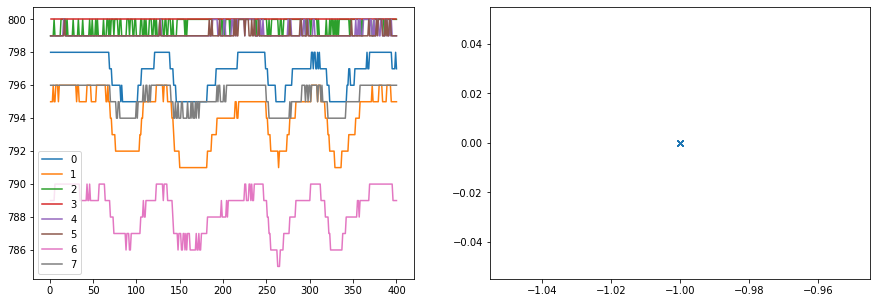

In [407]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

number = 255
Y_axis,coord = training_data['X'+str(number)],training_data['y'+str(number)]
X_axis = np.linspace(1,len(Y_axis),len(Y_axis))
print(Y_axis.shape)
for i in range(Y_axis.shape[1]):
    ax1.plot(X_axis,Y_axis[:,i],label = str(i))
ax1.legend()
ax2.plot(coord[:,0],coord[:,1],'x')

In [411]:
dataset_num = 45
X1_data = np.vstack((training_data['X'+str(i)] for i in range(226,226+dataset_num)))
y1_data = np.vstack((training_data['y'+str(i)] for i in range(226,226+dataset_num)))
X2_data = np.vstack((eval('X'+str(i)) for i in range(201,226)))
y2_data = np.vstack((eval('y'+str(i)) for i in range(201,226)))

X_data = np.vstack((X1_data,X2_data))
y_data = np.vstack((y1_data,y2_data))
scaler = pp.MinMaxScaler()
X_data = scaler.fit_transform(X_data)

print(X_data.shape,y_data.shape)
np.savetxt(r'D:\\signal_ntd_trackpad\V63_training_data.csv',np.hstack((X_data,y_data)),delimiter=",",fmt='%.3f')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

# model = Sequential()
# model.add(Dense(units = 100,activation="linear", input_dim=8))
# model.add(Dense(1000, activation="linear"))
# model.add(Dense(1000, activation="sigmoid"))
# model.add(Dense(1000, activation="linear"))
# model.add(Dense(1000, activation="relu"))
# model.add(Dense(1000, activation="linear"))
# model.add(Dense(1000, activation="linear"))
# model.add(Dense(2, activation="linear"))
# model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 20
batch_size = 128
with open('ntd_v63_trackpad_scaler.pkl', 'wb') as fid:
    pickle.dump(scaler, fid)
    
    
for i in range(50):
    history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test),verbose=1)
    os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
    print(os.getcwd())
    model.save('ntd_v63_trackpad_model.h5')
    


C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
C:\Users\TG0\Anaconda3\lib\site-pac

(28000, 8) (28000, 2)
Train on 18760 samples, validate on 9240 samples
Epoch 1/20
18760/18760 [==============================] - 16s 876us/step - loss: 0.0250 - acc: 0.9549 - val_loss: 0.0232 - val_acc: 0.9519
Epoch 2/20
18760/18760 [==============================] - 16s 868us/step - loss: 0.0250 - acc: 0.9557 - val_loss: 0.0253 - val_acc: 0.9315
Epoch 3/20
18760/18760 [==============================] - 16s 867us/step - loss: 0.0232 - acc: 0.9540 - val_loss: 0.0302 - val_acc: 0.9408
Epoch 4/20
18760/18760 [==============================] - 16s 872us/step - loss: 0.0283 - acc: 0.9568 - val_loss: 0.0246 - val_acc: 0.9429
Epoch 5/20
18760/18760 [==============================] - 16s 875us/step - loss: 0.0218 - acc: 0.9545 - val_loss: 0.0197 - val_acc: 0.9551
Epoch 6/20
18760/18760 [==============================] - 16s 872us/step - loss: 0.0218 - acc: 0.9526 - val_loss: 0.0271 - val_acc: 0.9355
Epoch 7/20
18760/18760 [==============================] - 16s 870us/step - loss: 0.0196 - acc: 

KeyboardInterrupt: 

# v6.4 define training data with surface area

In [ ]:
length=70
height=25

ratio_x = 1
ratio_y = 1

In [ ]:
def generate_straight_line_trining_data_gps(data,start,end,finger_pattern=[5,7,7,5]):
    X_data = []
    y_data = []
    start = np.array(start).astype(float)
    end = np.array(end).astype(float)
    data = data.loc[:,:].to_numpy()
    y_difference = (end - start)/resolution
    index_difference = len(data)/resolution
    index = 0
    coords = start
    X_data = data[int(np.round(index,0)),:]
    y_data = coords
    print(index,index_difference,start,y_difference)
    while True:
        index += index_difference
        coords += y_difference
        try: 
            X_data = np.vstack((X_data,data[int(np.round(index,0)),:]))
            y_data = np.vstack((y_data,coords))
        except:
            break
    
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    distance_1x = (y_data[:,0] + 2) * length / 4 
    distance_1y = (1 - y_data[:,1]) * height / 2
    distance_2x = (2 - y_data[:,0]) * length / 4 
    distance_2y = (1 - y_data[:,1]) * height / 2
    distance_3x = (y_data[:,0] + 2) * length / 4 
    distance_3y = (y_data[:,1] + 1) * height / 2
    distance_4x = (2 - y_data[:,0]) * length / 4 
    distance_4y = (y_data[:,1] +1) * height / 2
    distance={}
    for i in range(4):
        distance[i] = np.round(np.sqrt(eval('distance_'+str(i+1)+'x')**2 + eval('distance_'+str(i+1)+'y')**2) - finger_pattern[i],1)
    y_data = np.vstack((distance[0],distance[1],distance[2],distance[3])).T
    return X_data,y_data

In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

data = get_electrode_data('line_v6.4_1.csv')
plot_electrode_data(data)
# plt.xlim([70,510])

resolution = 100
data = get_electrode_data('line_v6.4_1.csv').loc[850:4350,:]
X_gps1,y_gps1 = generate_straight_line_trining_data_gps(data,[-2* ratio_x,1* ratio_y], [2* ratio_x,1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_2.csv').loc[450:3450,:]
X_gps2,y_gps2 = generate_straight_line_trining_data_gps(data,[-2* ratio_x,0* ratio_y], [2* ratio_x,0* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_3.csv').loc[700:4300,:]
X_gps3,y_gps3 = generate_straight_line_trining_data_gps(data,[-2* ratio_x,-1* ratio_y], [2* ratio_x,-1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_4.csv').loc[350:2800,:]
X_gps4,y_gps4 = generate_straight_line_trining_data_gps(data, [-2* ratio_x,1* ratio_y], [2* ratio_x,1* ratio_y])
data = get_electrode_data('line_v6.4_5.csv').loc[700:3200,:]
X_gps5,y_gps5 = generate_straight_line_trining_data_gps(data, [-2* ratio_x,0* ratio_y], [2* ratio_x,0* ratio_y])
data = get_electrode_data('line_v6.4_6.csv').loc[400:1700,:]
X_gps6,y_gps6 = generate_straight_line_trining_data_gps(data, [2* ratio_x,-1* ratio_y], [-2* ratio_x,-1* ratio_y], finger_pattern=[5,7,7,5])
data = get_electrode_data('line_v6.4_7.csv').loc[90:510,:]
X_gps7,y_gps7 = generate_straight_line_trining_data_gps(data, [2* ratio_x,1* ratio_y], [-2* ratio_x,1* ratio_y], finger_pattern=[5,7,7,5])
data = get_electrode_data('line_v6.4_8.csv').loc[90:490,:]
X_gps8,y_gps8 = generate_straight_line_trining_data_gps(data, [2* ratio_x,0* ratio_y], [-2* ratio_x,0* ratio_y], finger_pattern=[5,7,7,5])
data = get_electrode_data('line_v6.4_9.csv').loc[80:450,:]
X_gps9,y_gps9 = generate_straight_line_trining_data_gps(data, [-2* ratio_x,-1* ratio_y], [2* ratio_x,-1* ratio_y], finger_pattern=[5,7,7,5])
data = get_electrode_data('line_v6.4_10.csv').loc[50:430,:]
X_gps10,y_gps10 = generate_straight_line_trining_data_gps(data, [2* ratio_x,1* ratio_y], [-2* ratio_x,1* ratio_y], finger_pattern=[2.5,2.5,2.5,2.5])
data = get_electrode_data('line_v6.4_11.csv').loc[80:500,:]
X_gps11,y_gps11 = generate_straight_line_trining_data_gps(data, [2* ratio_x,0* ratio_y], [-2* ratio_x,0* ratio_y], finger_pattern=[2.5,2.5,2.5,2.5])
data = get_electrode_data('line_v6.4_12.csv').loc[70:510,:]
X_gps12,y_gps12 = generate_straight_line_trining_data_gps(data, [2* ratio_x,-1* ratio_y], [-2* ratio_x,-1* ratio_y], finger_pattern=[2.5,2.5,2.5,2.5])


data = get_electrode_data('line_v6.4_13.csv').loc[:,:]
X_gps13,y_gps13 = generate_straight_line_trining_data_gps(data, [-2* ratio_x,1* ratio_y], [-2* ratio_x,1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_14.csv').loc[:,:]
X_gps14,y_gps14 = generate_straight_line_trining_data_gps(data, [-2* ratio_x,0* ratio_y], [-2* ratio_x,0* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_15.csv').loc[:,:]
X_gps15,y_gps15 = generate_straight_line_trining_data_gps(data, [-2* ratio_x,-1* ratio_y], [-2* ratio_x,-1* ratio_y], finger_pattern=[2,2,2,2])
data = get_electrode_data('line_v6.4_16.csv').loc[:,:]
X_gps16,y_gps16 = generate_straight_line_trining_data_gps(data, [-1.143* ratio_x,1* ratio_y], [-1.143* ratio_x,1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_17.csv').loc[:,:]
X_gps17,y_gps17 = generate_straight_line_trining_data_gps(data, [-1.143* ratio_x,0* ratio_y], [-1.143* ratio_x,0* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_18.csv').loc[:,:]
X_gps18,y_gps18 = generate_straight_line_trining_data_gps(data, [-1.143* ratio_x,-1* ratio_y], [-1.143* ratio_x,-1* ratio_y], finger_pattern=[2,2,2,2])
data = get_electrode_data('line_v6.4_19.csv').loc[:,:]
X_gps19,y_gps19 = generate_straight_line_trining_data_gps(data, [0* ratio_x,1* ratio_y], [0* ratio_x,1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_20.csv').loc[:,:]
X_gps20,y_gps20 = generate_straight_line_trining_data_gps(data, [0* ratio_x,0* ratio_y], [0* ratio_x,0* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_21.csv').loc[:,:]
X_gps21,y_gps21 = generate_straight_line_trining_data_gps(data, [0* ratio_x,-1* ratio_y], [0* ratio_x,-1* ratio_y], finger_pattern=[2,2,2,2])
data = get_electrode_data('line_v6.4_22.csv').loc[:,:]
X_gps22,y_gps22 = generate_straight_line_trining_data_gps(data, [1.143* ratio_x,1* ratio_y], [1.143* ratio_x,1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_23.csv').loc[:,:]
X_gps23,y_gps23 = generate_straight_line_trining_data_gps(data, [1.143* ratio_x,0* ratio_y], [1.143* ratio_x,0* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_24.csv').loc[:,:]
X_gps24,y_gps24 = generate_straight_line_trining_data_gps(data, [1.143* ratio_x,-1* ratio_y], [1.143* ratio_x,-1* ratio_y], finger_pattern=[2,2,2,2])
data = get_electrode_data('line_v6.4_25.csv').loc[:,:]
X_gps25,y_gps25 = generate_straight_line_trining_data_gps(data, [2* ratio_x,1* ratio_y], [2* ratio_x,1* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_26.csv').loc[:,:]
X_gps26,y_gps26 = generate_straight_line_trining_data_gps(data, [2* ratio_x,0* ratio_y], [2* ratio_x,0* ratio_y], finger_pattern=[3,3,3,3])
data = get_electrode_data('line_v6.4_27.csv').loc[:,:]
X_gps27,y_gps27 = generate_straight_line_trining_data_gps(data, [2* ratio_x,-1* ratio_y], [2* ratio_x,-1* ratio_y], finger_pattern=[2,2,2,2])
# print(y_gps6)

In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def find_peak(data,height=0.2,distance=350):
    peaks={}
    adjusted_peaks = {}
    for electrode in data.columns:
        peaks[electrode] = find_peaks(data.loc[:,electrode],height = height, distance= distance)[0]
        value = data.loc[:,electrode].to_numpy()
        for i,index in enumerate(peaks[electrode]):
            try: 
                segment = value[int(index-distance/3):int(index+distance/3)]
                popt,pcov = curve_fit(gaus,np.linspace(int(index-distance/3),int(index+distance/3-1),
                                                       int(index+distance/3-1) - int(index-distance/3) + 1),
                                      segment,p0=[value[index],index,distance/4])
                peaks[electrode][i] = int(popt[1])
            except:
                continue
        print('number of peaks in electrode ', electrode, ' = ',len(peaks[electrode]))
    return peaks

def plot_peaks(data,peaks):
    for electrode in data.columns:
        plt.plot(data.index[peaks[electrode]],data.loc[peaks[electrode],electrode],'x')
        

def electrode_sequence(sequence):
    elec_sequence=[]
    for i in sequence:
        elec_sequence.append(pair[i])
    return elec_sequence

def rotate(l,n):
    return l[n:] + l[:n]

def arrange_peaks_seq(peaks,elec_sequence):
#     print(peaks)
    
    start = min(chain(*peaks.values()))
    
    for key in peaks.keys():
        if start in peaks[key]:
            start_electrode = key

    
    while True:
        print(elec_sequence,start_electrode)
        if elec_sequence[0] == start_electrode:
            break
        else:
            elec_sequence = rotate(elec_sequence,1)
    i = 0
    final_peak = []
    final_sequence = []
    prev_peak = 0
    while True:
#         print('electrode_sequence',elec_sequence,peaks,elec_sequence[i%len(elec_sequence)])
        cycle = int(i/len(elec_sequence))
        try:
            peak = peaks[elec_sequence[i%len(elec_sequence)]][0]
#             print('peaks ',elec_sequence[i%len(elec_sequence)],' has peaks ', peaks[elec_sequence[i%len(elec_sequence)]])
        except:
            break
        if peak > prev_peak:
#             print('adding peaks',i,peak)
            final_peak.append(peak)
            prev_peak = peak
            peaks[elec_sequence[i%len(elec_sequence)]] = peaks[elec_sequence[i%len(elec_sequence)]][1:]
            final_sequence.append(elec_sequence[i%len(elec_sequence)])
        else:
            print('error in finding peaks',prev_peak,peak)
            break
        i += 1
    return final_peak,final_sequence

def arrange_coord_seq(final_sequence,direction='clockwise'):
    final_coords = []
    for i,elec in enumerate(final_sequence):
        final_coords.append(location[final_sequence[i]])
    final_coords = np.array(final_coords)
    return final_coords


def create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[5,7,7,5]):
    X_data = data.loc[final_peak[0],:].to_numpy()
    y_data = np.array(final_coords[0])
    
    for i,index in enumerate(final_peak):
        try:
            index_difference = (final_peak[i+1] - final_peak[i])/resolution         
        except:
            break
        
        X = data.loc[int(index),:].to_numpy()
        y = np.array(final_coords[i]).astype(float)
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from ',y)
        for j in range(resolution):
#             print('>>>>>>>>>>>>>  ',X,y)
            X_data = np.vstack((X_data,X))
            y_data = np.vstack((y_data,y))
            index += index_difference
            X = data.loc[int(index),:].to_numpy()
#             print('inside training data collection loop: ',i)        
            y_difference = (final_coords[i+1] - final_coords[i])/resolution
            y += y_difference 
#             print(y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    distance_1x = (y_data[:,0] + 2) * length / 4 
    distance_1y = (1 - y_data[:,1]) * height / 2
    distance_2x = (2 - y_data[:,0]) * length / 4 
    distance_2y = (1 - y_data[:,1]) * height / 2
    distance_3x = (y_data[:,0] + 2) * length / 4 
    distance_3y = (y_data[:,1] + 1) * height / 2
    distance_4x = (2 - y_data[:,0]) * length / 4 
    distance_4y = (y_data[:,1] +1) * height / 2
    distance={}
    for i in range(4):
        distance[i] = np.round(np.sqrt(eval('distance_'+str(i+1)+'x')**2 + eval('distance_'+str(i+1)+'y')**2) - finger_pattern[i],1)
    y_data = np.vstack((distance[0],distance[1],distance[2],distance[3])).T
    return X_data,y_data

In [ ]:
pair = [0,1,2,3,8,9,10,11]
anticlock_sequence = [7,6,1,0]
clockwise_sequence = [0,1,6,7]
resolution = 40
location = {0:[-2*ratio_x,1*ratio_y],
            1:[0*ratio_x,1*ratio_y],
            2:[2*ratio_x,1*ratio_y],
            3:[0*ratio_x,1*ratio_y],
            8:[2*ratio_x,-1*ratio_y],
            9:[0*ratio_x,-1*ratio_y],
            10:[0*ratio_x,-1*ratio_y],
            11:[-2*ratio_x,-1*ratio_y]}


data = get_electrode_data('circle_v6.4_clockwise1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X_gps28,y_gps28  = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[3,3,3,3])


circle_direction = 'clockwise'
data = get_electrode_data('circle_v6.4_'+circle_direction+'2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps29,y_gps29  = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[7,7,7,7])


circle_direction = 'anticlock'
data = get_electrode_data('circle_v6.4_'+circle_direction+'1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps30,y_gps30 = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[3,3,3,3])


circle_direction = 'anticlock'
data = get_electrode_data('circle_v6.4_'+circle_direction+'2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps31,y_gps31  = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[7,7,7,7])

In [ ]:
pair = [0,1,2,3,8,9,10,11]
anticlock_sequence = [5,4,2,3]
clockwise_sequence = [3,2,4,5]
resolution = 40
location = {0:[-2*ratio_x,1*ratio_y],
            1:[0*ratio_x,1*ratio_y],
            2:[2*ratio_x,1*ratio_y],
            3:[0*ratio_x,1*ratio_y],
            8:[2*ratio_x,-1*ratio_y],
            9:[0*ratio_x,-1*ratio_y],
            10:[0*ratio_x,-1*ratio_y],
            11:[-2*ratio_x,-1*ratio_y]}

circle_direction = 'anticlock'
data = get_electrode_data('circle_v6.4_'+circle_direction+'3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps32,y_gps32 = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[3,3,3,3])


circle_direction = 'anticlock'
data = get_electrode_data('circle_v6.4_'+circle_direction+'4.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps33,y_gps33  = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[7,7,7,7])

circle_direction = 'clockwise'
data = get_electrode_data('circle_v6.4_'+circle_direction+'3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps34,y_gps34 = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[3,3,3,3])


data = get_electrode_data('circle_v6.4_'+circle_direction+'4.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.1,distance=250)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X_gps35,y_gps35  = create_training_data_square(data,final_peak,final_coords,height=25,length=70,finger_pattern=[7,7,7,7])

In [189]:
dataset_num = 35
X_data = np.vstack((eval('X_gps'+str(i)) for i in range(1,1+dataset_num)))
y_data = np.vstack((eval('y_gps'+str(i)) for i in range(1,1+dataset_num)))
# scaler = pp.MinMaxScaler()
# X_data = scaler.fit(X_data)
y_data = np.clip(y_data,0,np.inf)
print(X_data.shape,y_data.shape)
np.savetxt(r'D:\\signal_ntd_trackpad\V64_training_data.csv',np.hstack((X_data,y_data)),delimiter=",",fmt='%.3f')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

model = Sequential()
model.add(Dense(units = 8,activation="linear", input_dim=8))
model.add(Dense(16, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="linear"))
model.add(Dense(4, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 20
batch_size = 128
with open('ntd_v64_trackpad_scaler.pkl', 'wb') as fid:
    pickle.dump(scaler, fid)
    
    
for i in range(20):
    history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test),verbose=1)
    os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
    print(os.getcwd())
    model.save('ntd_v64_trackpad_model.h5')

C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


(16403, 8) (16403, 4)
Train on 10990 samples, validate on 5413 samples
Epoch 1/20
10990/10990 [==============================] - 2s 213us/step - loss: 598.3689 - acc: 0.2667 - val_loss: 397.8543 - val_acc: 0.2014
Epoch 2/20
10990/10990 [==============================] - 0s 39us/step - loss: 198.9591 - acc: 0.4256 - val_loss: 58.1152 - val_acc: 0.3953
Epoch 3/20
10990/10990 [==============================] - 0s 37us/step - loss: 55.2613 - acc: 0.4837 - val_loss: 54.4317 - val_acc: 0.4271
Epoch 4/20
10990/10990 [==============================] - 0s 38us/step - loss: 52.5276 - acc: 0.5194 - val_loss: 51.8720 - val_acc: 0.5502
Epoch 5/20
10990/10990 [==============================] - 0s 41us/step - loss: 48.8901 - acc: 0.6994 - val_loss: 45.5476 - val_acc: 0.8051
Epoch 6/20
10990/10990 [==============================] - 0s 38us/step - loss: 38.5662 - acc: 0.8012 - val_loss: 34.7395 - val_acc: 0.8154
Epoch 7/20
10990/10990 [==============================] - 0s 40us/step - loss: 32.1895 - ac

Epoch 18/20
10990/10990 [==============================] - 0s 41us/step - loss: 9.5541 - acc: 0.8318 - val_loss: 9.9615 - val_acc: 0.8860
Epoch 19/20
10990/10990 [==============================] - 0s 36us/step - loss: 9.4372 - acc: 0.8359 - val_loss: 9.3898 - val_acc: 0.8367
Epoch 20/20
10990/10990 [==============================] - 0s 37us/step - loss: 8.9515 - acc: 0.8417 - val_loss: 9.1347 - val_acc: 0.8356
D:\Python_projects\etee_server\etee_driver\models
Train on 10990 samples, validate on 5413 samples
Epoch 1/20
10990/10990 [==============================] - 0s 40us/step - loss: 9.0786 - acc: 0.8338 - val_loss: 10.4129 - val_acc: 0.8199
Epoch 2/20
10990/10990 [==============================] - 0s 39us/step - loss: 9.2150 - acc: 0.8358 - val_loss: 9.7276 - val_acc: 0.8914
Epoch 3/20
10990/10990 [==============================] - 0s 45us/step - loss: 8.9961 - acc: 0.8334 - val_loss: 9.4866 - val_acc: 0.7837
Epoch 4/20
10990/10990 [==============================] - 0s 36us/step - lo

KeyboardInterrupt: 

In [198]:
params = {'n_estimators': 1000, 'max_depth': 8, 'min_samples_split': 20,
          'learning_rate': 0.01, 'loss': 'ls','verbose': 1}
clf0 = ensemble.GradientBoostingRegressor(**params)
clf1 = ensemble.GradientBoostingRegressor(**params)
clf2 = ensemble.GradientBoostingRegressor(**params)
clf3 = ensemble.GradientBoostingRegressor(**params)

clf0.fit(X_train, y_train[:,0])
mse = mean_squared_error(y_test[:,0], clf0.predict(X_test))

print("MSE: %.4f" % mse)

    
clf1.fit(X_train, y_train[:,1])
mse = mean_squared_error(y_test[:,1], clf1.predict(X_test))

print("MSE: %.4f" % mse)
    
    
clf2.fit(X_train, y_train[:,2])
mse = mean_squared_error(y_test[:,2], clf2.predict(X_test))

print("MSE: %.4f" % mse)

    
clf3.fit(X_train, y_train[:,3])
mse = mean_squared_error(y_test[:,3], clf3.predict(X_test))

print("MSE: %.4f" % mse)
with open('ntd_v65_trackpad_model.pkl', 'wb') as fid:
pickle.dump([clf0,clf1,clf2,clf3], fid)

      Iter       Train Loss   Remaining Time 
         1         400.0378           26.92s
         2         392.2054           26.87s
         3         384.5304           26.51s
         4         377.0064           26.58s
         5         369.6331           26.60s
         6         362.4057           26.44s
         7         355.3228           26.45s
         8         348.3802           26.46s
         9         341.5761           26.35s
        10         334.9049           26.36s
        20         275.0690           25.70s
        30         226.0918           25.25s
        40         185.9607           25.40s
        50         153.0999           24.94s
        60         126.1682           24.50s
        70         104.1120           24.15s
        80          86.0419           23.91s
        90          71.2369           23.56s
       100          59.0885           23.25s
       200          11.1429           20.96s
       300           4.1285           18.42s
       40

[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.4 21.7 22.8
 18.8 18.7 18.5 18.3 21.2 19.2 20.4 19.3 22.  20.3 20.5 17.3 18.8 21.4
 15.7 16.2 18.  14.3 19.2 19.6 23.  18.4 15.6 18.1 17.4 17.1 13.3 17.8
 14.  14.4 13.4 15.6 11.8 13.8 15.6 14.6 17.8 15.4 21.5 19.6 15.3 19.4
 17.  15.6 13.1 41.3 24.3 23.3 27.  50.  50.  50.  22.7 25.  50.  23.8
 23.8 22.3 17.4 19.1 23.1 23.6 22.6 29.4 23.2 24.6 29.9 37.2 39.8 36.2
 37.9 32.5 26.4 29.6 50.  32.  29.8 34.9 37.  30.5 36.4 31.1 29.1 50.
 33.3 3